# Install deps and log in to wandb

In [ ]:
!pip install -q diffusers datasets wandb

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Set Up Dataloaders

In [4]:
#@title imports
import wandb
import torch
import torchvision
from torch import nn
from torchvision import transforms as T
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
#@title dataset from HF
from torchvision import transforms as T
from datasets import load_dataset
flowers = load_dataset('huggan/flowers-102-categories')
tfm = T.Compose([T.Resize(64), T.CenterCrop(64)])
def transforms(examples):
    examples["image"] = [tfm(image.convert("RGB")) for image in examples["image"]]
    return examples
flowers = flowers.with_transform(transforms)['train']

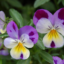

In [6]:
# Example 64px image
flowers[0]['image']

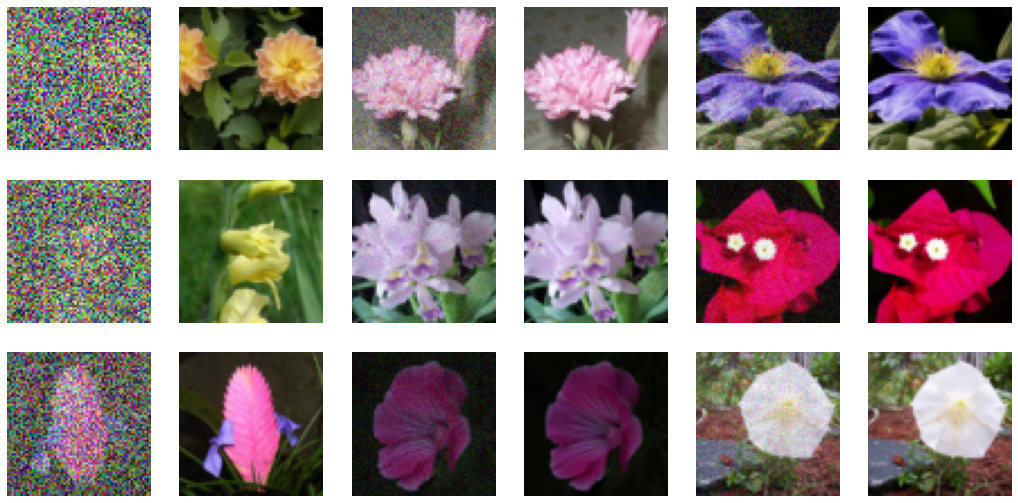

In [7]:
# Class for crappified image
class PILImageNoised(PILImage): pass
class TensorImageNoised(TensorImage):
    def show(self, ctx=None, **kwargs):
        super().show(ctx=ctx, **kwargs)
PILImageNoised._tensor_cls = TensorImageNoised

# Transform (TODO experiment)
class Crappify(Transform):
    def encodes(self, x:TensorImageNoised): 
        x = IntToFloatTensor()(x)
        blurred = T.GaussianBlur(3)(x) # Add some random blur
        noise_amount = torch.rand(x.shape[0], device=x.device)
        noise = torch.rand_like(x, device=x.device)
        noised = torch.lerp(blurred, noise, noise_amount.view(-1, 1, 1, 1)) * 255
        return noised

# Dataloader
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageNoised),ImageBlock(cls=PILImage)),
                   get_items=lambda pth: range(len(flowers)), # Gets the indexes
                   getters=[lambda idx: np.array(flowers[idx]['image'])]*2,
                   batch_tfms=[Crappify])
dls = dblock.dataloaders('', bs=128)
dls.show_batch()

# Model and training

In [29]:
#@title The unet model
from diffusers import UNet2DModel

class Unetwrapper(Module):
    def __init__(self, in_channels=3, out_channels=3, sample_size=64):
        super().__init__()
        self.net = UNet2DModel(
            sample_size=sample_size,  # the target image resolution
            in_channels=in_channels,  # the number of input channels, 3 for RGB images
            out_channels=out_channels,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(64, 64, 64, 64),  # <<< Experiment with number of layers and how many
            down_block_types=( 
                "DownBlock2D",  # a regular ResNet downsampling block
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention (uses lots of memory at higher resolutions - better to keep at lowest level or two)
            ), 
            up_block_types=(
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D", 
                "UpBlock2D",
                "UpBlock2D",
              ),
        )
    def forward(self, x): return self.net(x, 100).sample # Not timestep conditioning here

model = Unetwrapper().to(device)

SuggestedLRs(valley=9.120108734350652e-05)

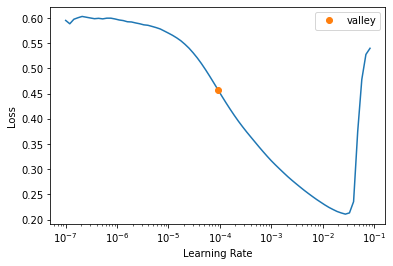

In [30]:
# Create a learner and pick LR
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.lr_find()

In [31]:
#@title Callback for logging samples (shown later in sampling section)
from PIL import Image as PILImage
class LogSamplesBasicCallback(Callback):
    def after_epoch(self):
      model = self.learn.model
      n_steps = 40
      x = torch.rand(64, 3, 64, 64).to(device)

      for i in range(n_steps):
        with torch.no_grad():
          pred = model(x)
        mix_factor = 1/(n_steps - i)
        x = x*(1-mix_factor) + pred*mix_factor

      im = torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0).clip(0, 1) * 255
      im = PILImage.fromarray(np.array(im).astype(np.uint8))
      wandb.log({'Sample generations basic':wandb.Image(im)})

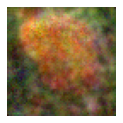

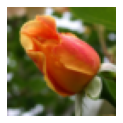

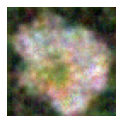

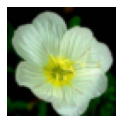

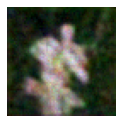

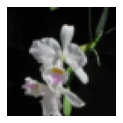

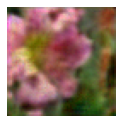

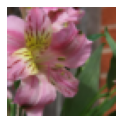

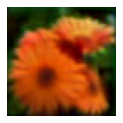

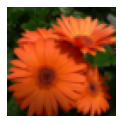

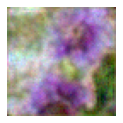

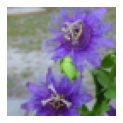

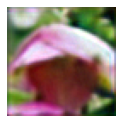

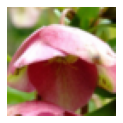

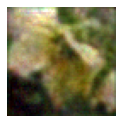

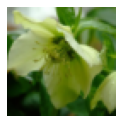

In [32]:
# Train a bit
cfg = dict(model.net.config)
cfg['num_epochs'] = 10
cfg['lr_max'] = 1e-4
cfg['comments'] = 'first test run with logging'
cfg['dataset'] = 'flowers'
wandb.init(project='fastdiffusion', job_type='quick train', config=cfg)
learn.fit_one_cycle(cfg['num_epochs'], lr_max=cfg['lr_max'], cbs=[WandbCallback(n_preds=8), LogSamplesBasicCallback()])
wandb.finish()

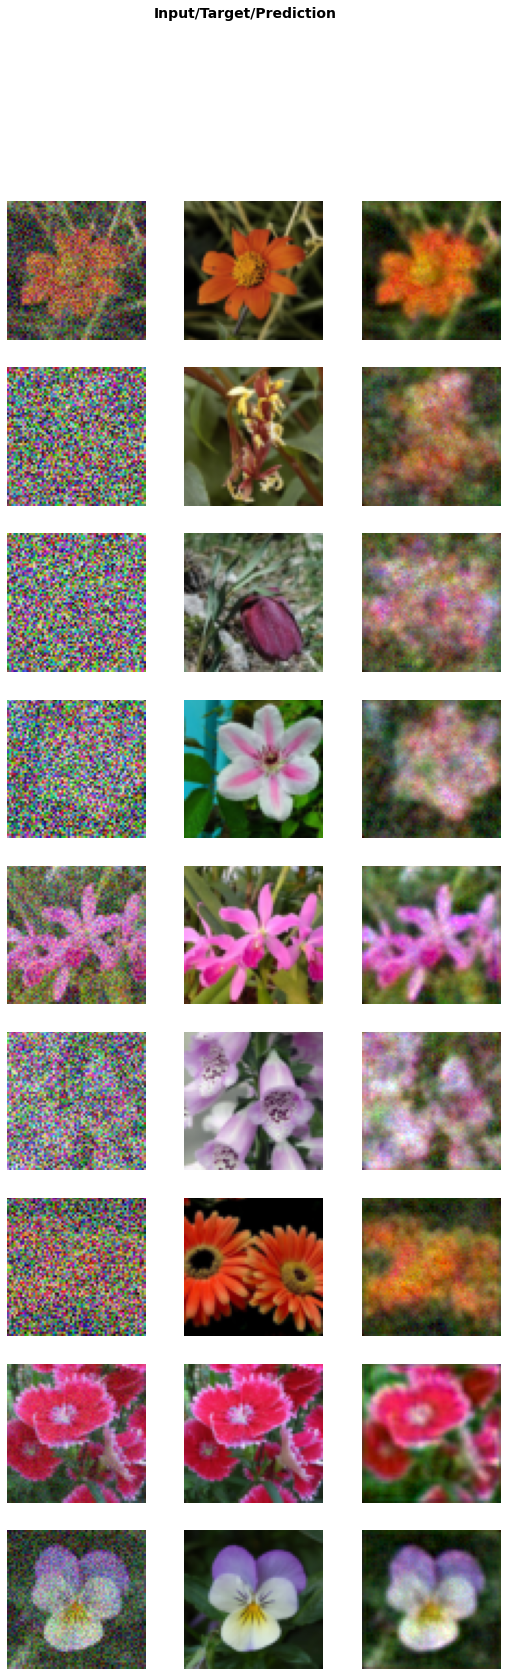

In [33]:
learn.show_results()

# Sampling

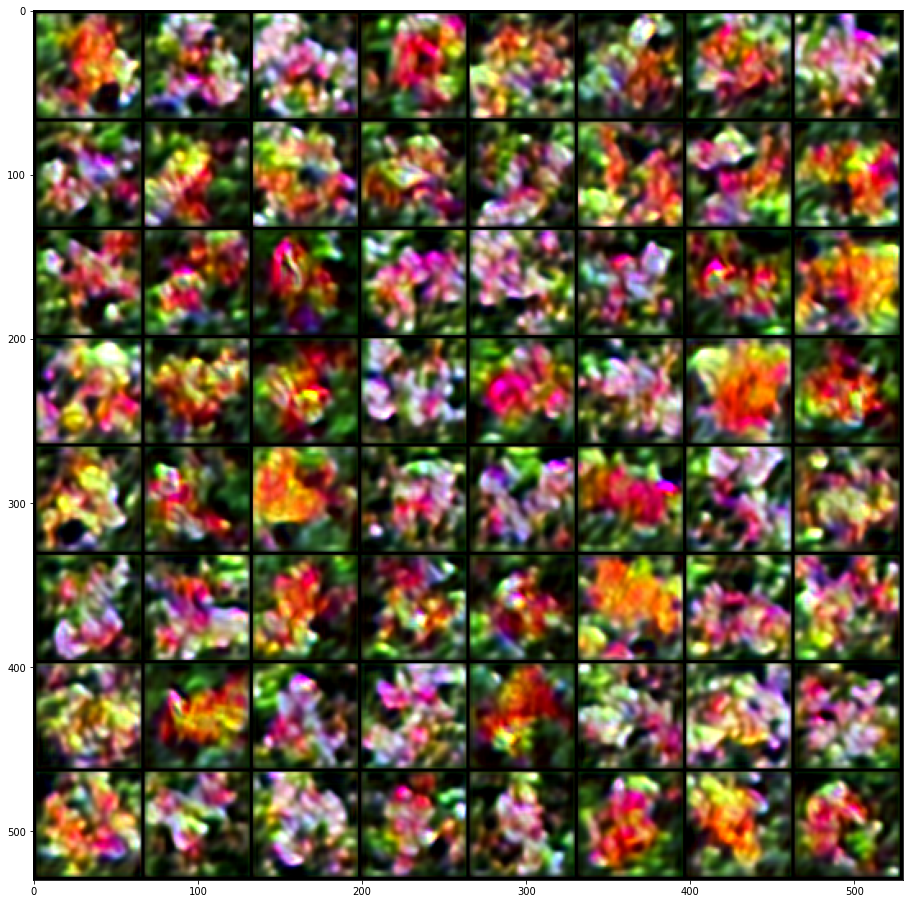

In [34]:
#@title sample with naive method from first test
n_steps = 40 # Set steps to 1 to see raw preds on first input
x = torch.rand(64, 3, 64, 64).to(device) # Raw noise starting point

for i in range(n_steps):
  with torch.no_grad():
    pred = model(x)
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0))

0 tensor(0.1126, device='cuda:0') tensor(0.0928, device='cuda:0') tensor(0.0928, device='cuda:0')
10 tensor(0.0702, device='cuda:0') tensor(0.0678, device='cuda:0') tensor(0.0678, device='cuda:0')
20 tensor(0.0635, device='cuda:0') tensor(0.0486, device='cuda:0') tensor(0.0486, device='cuda:0')
30 tensor(0.0631, device='cuda:0') tensor(0.0339, device='cuda:0') tensor(0.0339, device='cuda:0')
40 tensor(0.0545, device='cuda:0') tensor(0.0244, device='cuda:0') tensor(0.0244, device='cuda:0')
50 tensor(0.0448, device='cuda:0') tensor(0.0179, device='cuda:0') tensor(0.0179, device='cuda:0')
60 tensor(0.0371, device='cuda:0') tensor(0.0134, device='cuda:0') tensor(0.0134, device='cuda:0')


70 tensor(0.0317, device='cuda:0') tensor(0.0102, device='cuda:0') tensor(0.0102, device='cuda:0')
Stopping at: 71


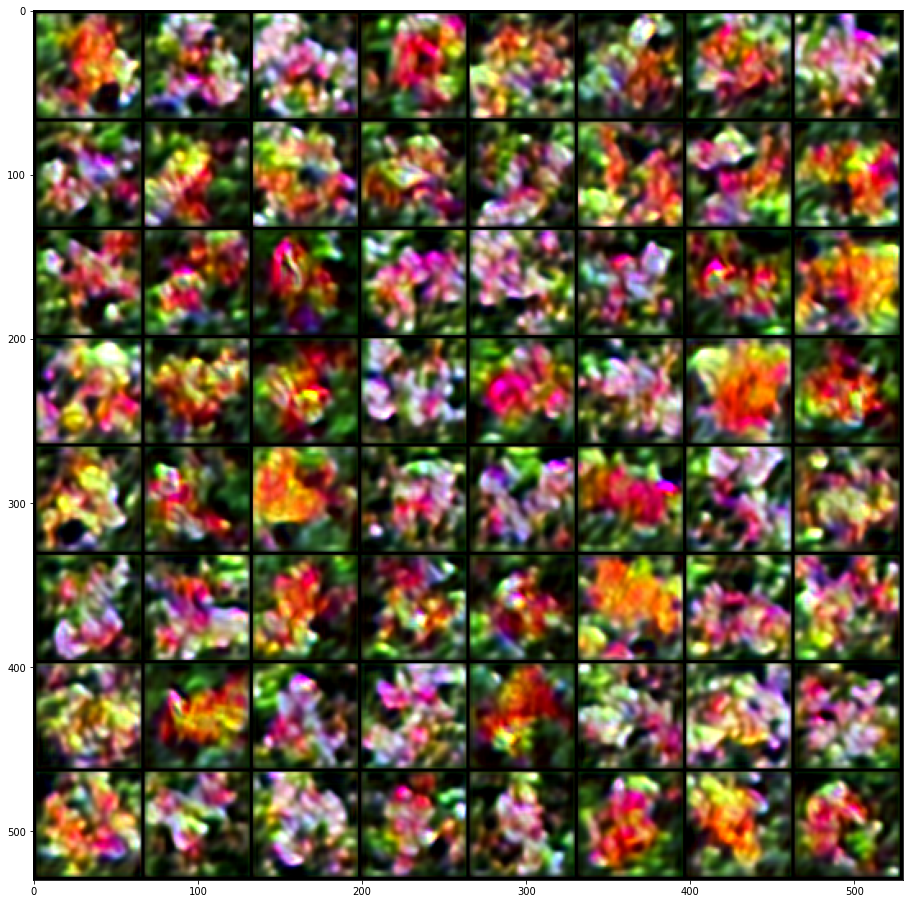

In [35]:
#@title sample with an optimiser
n_steps = 150 # We can stop early if pred noise is close to 0
x = torch.rand(64, 3, 64, 64).to(device)
x.requires_grad = True

base_lr=8e-3
# optim = torch.optim.SGD([x], lr=base_lr, momentum=0.1)
optim = torch.optim.Adam([x], lr=base_lr)

for i in range(n_steps):
  with torch.no_grad():
    net_output = model(x)
    noise_pred = x - net_output

  # # Early stopping
  if (noise_pred.float()).var() < 0.01 or i == n_steps-1:
    x = pred
    print('Stopping at:', i)
    break

  # noise_pred is basically the grad, so GD on this should find a minimum!
  x.grad = noise_pred.float()
  if i%10==0:print(i, x.grad.mean(), x.grad.var(), noise_pred.float().var()) # Useful to watch the noise variance
  optim.step()
  optim.zero_grad() # Not really needed since we're setting .grad ourselves but anyway...

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8).permute(1, 2, 0))